# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [11]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.6) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

print(X_train_feats.shape)

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [5e-9, 1e-7]
regularization_strengths = [5e4, 5e6]
num_iters = [3000,7000]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################


def acc_eval(X_train, y_train, X_val, y_val, model, verbose=False):
    y_train_pred = model.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)
    y_val_pred = model.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)
    if verbose:
        print('training accuracy: %f, validation accuracy: %f' % (acc_train, acc_val ))
    return acc_train, acc_val

def generatemesh(intervals_list, nxs_list, splitx_list):

    
    axis_list = []
    for i,inter in enumerate(intervals_list):
        if splitx_list[i] == 'line':
            locals()['x' + str(int(i))] = np.linspace(inter[0], inter[1], num=nxs_list[i])
        elif splitx_list[i] == 'log':
            locals()['x' + str(int(i))] = np.logspace(np.log10(inter[0]), np.log10(inter[1]), num=nxs_list[i])
        else:
            assert splitx_list[i] == 'line' or 'log' 'split mode should be "line" or "log"'
        axis_list.append(locals()['x' + str(int(i))])
    
    grids_list = np.meshgrid(*axis_list)
    for i, grid in enumerate(grids_list):
        grids_list[i] = grids_list[i].ravel()
    points = list(zip(*grids_list))
    return points

intervals_list = [learning_rates, regularization_strengths, num_iters]; nxs_list = [6,5,4]; splitx_list=['log', 'log', 'line']
points = generatemesh(intervals_list, nxs_list, splitx_list)

print('Roughly search')
best_lr = 0; best_reg=0; best_ni = 0
for i,xy in enumerate(points):
    model = LinearSVM()
    lr = xy[0]; reg = xy[1]; ni = int(xy[2])
    print('No.%d parameter combination' %(int(i)+1))
    print('learning rate = %2.2e, regularization strength = %2.2e, num_iters = %d' %(lr, reg, ni))
    model.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=ni)
    acc_train, acc_val = acc_eval(X_train_feats, y_train, X_val_feats, y_val, model, verbose=True)
    results[(lr,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_svm = model
        best_lr = lr; best_reg = reg; best_ni = ni
        
        
print('Detailed search')
learning_rates = [best_lr*0.8, best_lr*1.2] 
regularization_strengths = [best_reg*0.8, best_reg*1.2]        
num_iters = [int(best_ni*0.8), int(best_ni*1.2)]  

intervals_list = [learning_rates, regularization_strengths, num_iters]; nxs_list = [4,4,4]; splitx_list=['log', 'log', 'log']
points = generatemesh(intervals_list, nxs_list, splitx_list)

for i,xy in enumerate(points):
    model = LinearSVM()
    lr = xy[0]; reg = xy[1]; ni = int(xy[2])
    print('No.%d parameter combination' %(int(i)+1))
    print('learning rate = %2.2e, regularization strength = %2.2e, num_iters = %d' %(lr, reg, ni))
    model.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=ni)
    acc_train, acc_val = acc_eval(X_train_feats, y_train, X_val_feats, y_val, model, verbose=True)
    results[(lr,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_svm = model


        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Roughly search
No.1 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+04, num_iters = 3000
training accuracy: 0.070633, validation accuracy: 0.078000
No.2 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+04, num_iters = 4333
training accuracy: 0.128429, validation accuracy: 0.128000
No.3 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+04, num_iters = 5666
training accuracy: 0.100122, validation accuracy: 0.086000
No.4 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+04, num_iters = 7000
training accuracy: 0.152184, validation accuracy: 0.173000
No.5 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+04, num_iters = 3000
training accuracy: 0.137612, validation accuracy: 0.135000
No.6 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+04, num_iters = 4333
training accuracy: 0.182265, validation accuracy: 0.17

training accuracy: 0.415592, validation accuracy: 0.423000
No.51 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+05, num_iters = 5666
training accuracy: 0.415163, validation accuracy: 0.420000
No.52 parameter combination
learning rate = 5.00e-09, regularization strength = 5.00e+05, num_iters = 7000
training accuracy: 0.414490, validation accuracy: 0.415000
No.53 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+05, num_iters = 3000
training accuracy: 0.416429, validation accuracy: 0.417000
No.54 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+05, num_iters = 4333
training accuracy: 0.414286, validation accuracy: 0.409000
No.55 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+05, num_iters = 5666
training accuracy: 0.412980, validation accuracy: 0.415000
No.56 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+05, num_iters = 7000
trai

training accuracy: 0.407531, validation accuracy: 0.406000
No.101 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+06, num_iters = 3000
training accuracy: 0.401265, validation accuracy: 0.412000
No.102 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+06, num_iters = 4333
training accuracy: 0.403735, validation accuracy: 0.396000
No.103 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+06, num_iters = 5666
training accuracy: 0.410592, validation accuracy: 0.429000
No.104 parameter combination
learning rate = 9.10e-09, regularization strength = 5.00e+06, num_iters = 7000
training accuracy: 0.403245, validation accuracy: 0.414000
No.105 parameter combination
learning rate = 1.66e-08, regularization strength = 5.00e+06, num_iters = 3000
training accuracy: 0.407510, validation accuracy: 0.406000
No.106 parameter combination
learning rate = 1.66e-08, regularization strength = 5.00e+06, num_iters = 433

training accuracy: 0.410551, validation accuracy: 0.417000
No.31 parameter combination
learning rate = 6.59e-08, regularization strength = 4.58e+05, num_iters = 7338
training accuracy: 0.410878, validation accuracy: 0.408000
No.32 parameter combination
learning rate = 6.59e-08, regularization strength = 4.58e+05, num_iters = 8399
training accuracy: 0.412612, validation accuracy: 0.423000
No.33 parameter combination
learning rate = 4.39e-08, regularization strength = 5.24e+05, num_iters = 5599
training accuracy: 0.414184, validation accuracy: 0.418000
No.34 parameter combination
learning rate = 4.39e-08, regularization strength = 5.24e+05, num_iters = 6410
training accuracy: 0.414490, validation accuracy: 0.415000
No.35 parameter combination
learning rate = 4.39e-08, regularization strength = 5.24e+05, num_iters = 7338
training accuracy: 0.414429, validation accuracy: 0.423000
No.36 parameter combination
learning rate = 4.39e-08, regularization strength = 5.24e+05, num_iters = 8399
trai

In [9]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.427


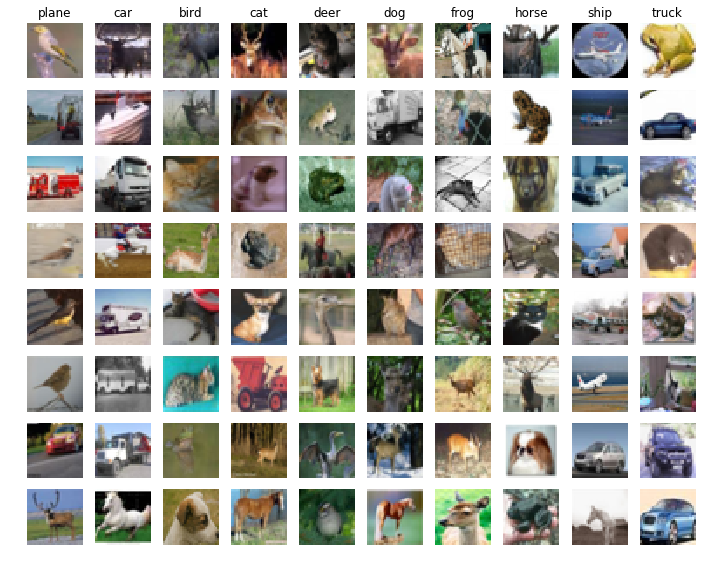

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?
Some of the misclassification picutres have similar background colors, and some have similar sharp. They do make sense, because the features exacted are the histogram of colors and textures of the images. 

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [13]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [14]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 100
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
from time import time
results = {}
best_val = -1
best_net = None
best_state = None

hidden_sizes = [500,500]
learning_rates = [5e-2, 5e-1]
num_iters = [1000, 7000]
regs = [5e-4, 3e-3]

num_classes = 10
input_size = input_dim

def acc_eval(X_train, y_train, X_val, y_val, model, verbose=False):
    y_train_pred = model.predict(X_train)
    acc_train = np.mean(y_train == y_train_pred)
    y_val_pred = model.predict(X_val)
    acc_val = np.mean(y_val == y_val_pred)
    if verbose:
        print('training accuracy: %f, validation accuracy: %f' % (acc_train, acc_val ))
    return acc_train, acc_val

def generatemesh(intervals_list, nxs_list, splitx_list):
    # x represents learning_rate, y represents regularization strength
    
    axis_list = []
    for i,inter in enumerate(intervals_list):
        if splitx_list[i] == 'line':
            locals()['x' + str(int(i))] = np.linspace(inter[0], inter[1], num=nxs_list[i])
        elif splitx_list[i] == 'log':
            locals()['x' + str(int(i))] = np.logspace(np.log10(inter[0]), np.log10(inter[1]), num=nxs_list[i])
        else:
            assert splitx_list[i] == 'line' or 'log' 'split mode should be "line" or "log"'
        axis_list.append(locals()['x' + str(int(i))])
    
    grids_list = np.meshgrid(*axis_list)
    for i, grid in enumerate(grids_list):
        grids_list[i] = grids_list[i].ravel()
    points = list(zip(*grids_list))
    return points

intervals_list = [hidden_sizes, learning_rates, num_iters, regs]; nxs_list = [1, 5, 5, 1]; splitx_list=['line', 'log', 'log', 'line']
points = generatemesh(intervals_list, nxs_list, splitx_list)

print('Roughly search')
for i,xy in enumerate(points):
    t1 = time()
    hs = int(xy[0]); lr = xy[1]; ni = int(xy[2]); reg = xy[3]
    print('# %d parameter combination' %(int(i)+1))
    print('hidden_size = %d, learning rate = %2.2e, num_iters = %d, regularization strength = %2.2e' %(hs, lr,ni, reg))
    model = TwoLayerNet(input_size, hs, num_classes)
    state = model.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=ni, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, keep_prob=0.5, verbose=False)
    acc_train, acc_val = acc_eval(X_train_feats, y_train, X_val_feats, y_val, model, verbose=True)
    results[(hs,lr,ni,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_net = model
        best_state = state
        best_hs = hs; best_lr = lr; best_ni = ni; best_reg = reg
    t2 = time()
    print('using time = %.3f' %(t2-t1))

print('detailed search')
hidden_sizes=[500,500]
learning_rates = [best_lr*0.8, best_lr*1.2] 
num_iters = [int(best_ni*0.8), int(best_ni*1.2)]
regs = regs
intervals_list = [hidden_sizes, learning_rates, num_iters, regs]; nxs_list = [1, 3, 3, 3]; splitx_list=['line', 'log', 'log', 'log']
points = generatemesh(intervals_list, nxs_list, splitx_list)

for i,xy in enumerate(points):
    t1 = time()
    hs = int(xy[0]); lr = xy[1]; ni = int(xy[2]); reg = xy[3]
    print('# %d parameter combination' %(int(i)+1))
    print('hidden_size = %d, learning rate = %2.2e, num_iters = %d, regularization strength = %2.2e' %(hs, lr,ni, reg))
    model = TwoLayerNet(input_size, hs, num_classes)
    state = model.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=ni, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, keep_prob=0.5, verbose=False)
    acc_train, acc_val = acc_eval(X_train_feats, y_train, X_val_feats, y_val, model, verbose=True)
    results[(hs,lr,ni,reg)] = (acc_train, acc_val)
    if best_val <= acc_val:
        best_val = acc_val
        best_net = model
        best_state = state
        best_hs = hs; best_lr = lr; best_ni = ni; best_reg = reg
    t2 = time()
    print('using time = %.3f' %(t2-t1))


#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################
# Print out results.
for hs,lr,ni,reg in sorted(results):
    train_accuracy, val_accuracy = results[(hs,lr,ni,reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Roughly search
# 1 parameter combination
hidden_size = 500, learning rate = 5.00e-02, num_iters = 1000, regularization strength = 5.00e-04
training accuracy: 0.447020, validation accuracy: 0.427000
using time = 6.754
# 2 parameter combination
hidden_size = 500, learning rate = 5.00e-02, num_iters = 1626, regularization strength = 5.00e-04
training accuracy: 0.501796, validation accuracy: 0.492000
using time = 10.977
# 3 parameter combination
hidden_size = 500, learning rate = 5.00e-02, num_iters = 2645, regularization strength = 5.00e-04
training accuracy: 0.531918, validation accuracy: 0.517000
using time = 18.011
# 4 parameter combination
hidden_size = 500, learning rate = 5.00e-02, num_iters = 4303, regularization strength = 5.00e-04
training accuracy: 0.550408, validation accuracy: 0.534000
using time = 30.166
# 5 parameter combination
hidden_size = 500, learning rate = 5.00e-02, num_iters = 7000, regularization strength = 5.00e-04
training accuracy: 0.568122, validation accuracy: 

training accuracy: 0.722612, validation accuracy: 0.603000
using time = 73.302
# 17 parameter combination
hidden_size = 500, learning rate = 1.55e-01, num_iters = 8399, regularization strength = 1.22e-03
training accuracy: 0.685020, validation accuracy: 0.609000
using time = 72.656
# 18 parameter combination
hidden_size = 500, learning rate = 1.55e-01, num_iters = 8399, regularization strength = 3.00e-03
training accuracy: 0.626408, validation accuracy: 0.581000
using time = 71.697
# 19 parameter combination
hidden_size = 500, learning rate = 1.90e-01, num_iters = 5599, regularization strength = 5.00e-04
training accuracy: 0.716939, validation accuracy: 0.590000
using time = 47.956
# 20 parameter combination
hidden_size = 500, learning rate = 1.90e-01, num_iters = 5599, regularization strength = 1.22e-03
training accuracy: 0.685633, validation accuracy: 0.597000
using time = 48.873
# 21 parameter combination
hidden_size = 500, learning rate = 1.90e-01, num_iters = 5599, regularization 

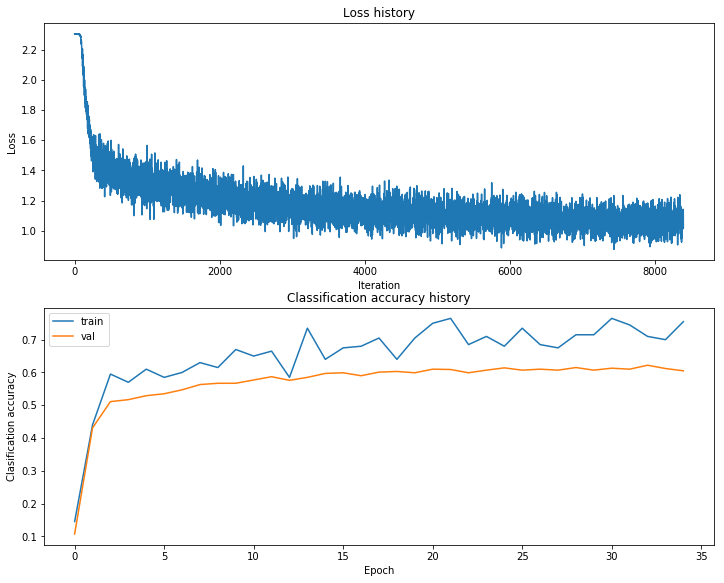

In [15]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_state['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_state['train_acc_history'], label='train')
plt.plot(best_state['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [16]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.588
